In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/final-sem-data/sem-dataset/stage1/README.dataset.txt
/kaggle/input/final-sem-data/sem-dataset/stage1/README.roboflow.txt
/kaggle/input/final-sem-data/sem-dataset/stage1/valid/defect/crack_image_50_png.rf.ce120a785448870198c7c4134b11b314.jpg
/kaggle/input/final-sem-data/sem-dataset/stage1/valid/defect/short_image_40_png.rf.03a34c0824f7c32983f413a8d8b0c492.jpg
/kaggle/input/final-sem-data/sem-dataset/stage1/valid/defect/open_image_17_png.rf.071c538dac6a0a85711bdbe008349f4d.jpg
/kaggle/input/final-sem-data/sem-dataset/stage1/valid/defect/short_image_42_png.rf.153c81d432112d1a71c365fb8292ea95.jpg
/kaggle/input/final-sem-data/sem-dataset/stage1/valid/defect/LER_image_53_png.rf.3d93880deb034d22a9a0fc9d01582c3b.jpg
/kaggle/input/final-sem-data/sem-dataset/stage1/valid/defect/short_image_34_png.rf.c6308e159eec266bbee981fe562ac5c7.jpg
/kaggle/input/final-sem-data/sem-dataset/stage1/valid/defect/malformed_via_image_64_png.rf.ce58cddeb92578ac4def52b0d6ab0ef4.jpg
/kaggle/input/final-

STEP 2: Imports & Global Config

In [3]:
import os
import torch
import numpy as np
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v3_small
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
EPOCHS = 15
LR = 1e-4

print(torch.cuda.is_available())

True


#STEP 3: Transforms (Grayscale → RGB)

In [5]:
transform = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


STEP 4: Helper Functions (IMPORTANT)

In [6]:
#data set loader
def get_loaders(root):
    train_ds = ImageFolder(os.path.join(root, "train"), transform=transform)
    val_ds   = ImageFolder(os.path.join(root, "valid"), transform=transform)
    test_ds  = ImageFolder(os.path.join(root, "test"), transform=transform)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)

    from collections import Counter

    counts = Counter(train_ds.targets)
    for k, v in counts.items():
        print(train_ds.classes[k], v)


    return train_loader, val_loader, test_loader, train_ds.classes


In [7]:
#model builder
def build_model(num_classes):
    state_dict = torch.load(
    "/kaggle/input/pretrained/mobilenet_v3_small-047dcff4.pth",
    map_location="cpu")
    model = mobilenet_v3_small(weights=None)

    model.load_state_dict(state_dict)
    model.classifier[3] = nn.Linear(
        model.classifier[3].in_features,
        num_classes
    )
    return model.to(DEVICE)


In [8]:
#Training loop
def train_model(model, train_loader, val_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    for epoch in range(EPOCHS):
        model.train()
        for x, y in tqdm(train_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                pred = model(x).argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)

        print(f"Epoch {epoch+1}/{EPOCHS} | Val Acc: {100*correct/total:.2f}%")


In [9]:
#evaluation function
def evaluate_model(model, test_loader, class_names, title):
    y_true, y_pred = [], []

    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(DEVICE)
            pred = model(x).argmax(1).cpu().numpy()
            y_true.extend(y.numpy())
            y_pred.extend(pred)

    print(f"\n📊 {title} Accuracy:",
          f"{accuracy_score(y_true, y_pred)*100:.2f}%\n")

    print("📄 Classification Report")
    print(classification_report(
        y_true, y_pred, target_names=class_names
    ))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


STEP 5: Stage-1 Training (Clean vs Defect)

clean 256
defect 261
Stage-1 classes: ['clean', 'defect']


100%|██████████| 17/17 [00:05<00:00,  3.39it/s]


Epoch 1/15 | Val Acc: 82.46%


100%|██████████| 17/17 [00:02<00:00,  7.93it/s]


Epoch 2/15 | Val Acc: 85.09%


100%|██████████| 17/17 [00:02<00:00,  7.97it/s]


Epoch 3/15 | Val Acc: 81.58%


100%|██████████| 17/17 [00:02<00:00,  6.86it/s]


Epoch 4/15 | Val Acc: 79.82%


100%|██████████| 17/17 [00:02<00:00,  7.29it/s]


Epoch 5/15 | Val Acc: 76.32%


100%|██████████| 17/17 [00:02<00:00,  7.73it/s]


Epoch 6/15 | Val Acc: 80.70%


100%|██████████| 17/17 [00:02<00:00,  8.23it/s]


Epoch 7/15 | Val Acc: 82.46%


100%|██████████| 17/17 [00:02<00:00,  7.76it/s]


Epoch 8/15 | Val Acc: 83.33%


100%|██████████| 17/17 [00:02<00:00,  7.73it/s]


Epoch 9/15 | Val Acc: 85.09%


100%|██████████| 17/17 [00:02<00:00,  7.75it/s]


Epoch 10/15 | Val Acc: 85.96%


100%|██████████| 17/17 [00:02<00:00,  7.80it/s]


Epoch 11/15 | Val Acc: 87.72%


100%|██████████| 17/17 [00:02<00:00,  7.83it/s]


Epoch 12/15 | Val Acc: 89.47%


100%|██████████| 17/17 [00:02<00:00,  7.70it/s]


Epoch 13/15 | Val Acc: 88.60%


100%|██████████| 17/17 [00:02<00:00,  7.96it/s]


Epoch 14/15 | Val Acc: 91.23%


100%|██████████| 17/17 [00:02<00:00,  7.88it/s]


Epoch 15/15 | Val Acc: 89.47%

📊 Stage-1: Clean vs Defect Accuracy: 81.08%

📄 Classification Report
              precision    recall  f1-score   support

       clean       0.83      0.79      0.81        56
      defect       0.79      0.84      0.81        55

    accuracy                           0.81       111
   macro avg       0.81      0.81      0.81       111
weighted avg       0.81      0.81      0.81       111



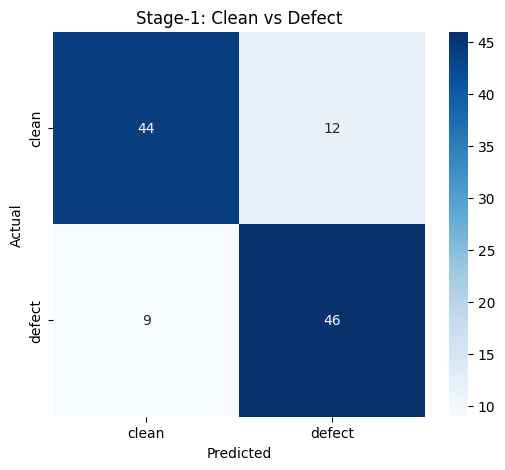

In [10]:
STAGE1_ROOT = "/kaggle/input/final-sem-data/sem-dataset/stage1"

train_l, val_l, test_l, classes = get_loaders(STAGE1_ROOT)
print("Stage-1 classes:", classes)

model_s1 = build_model(num_classes=2)
train_model(model_s1, train_l, val_l)

torch.save(
    model_s1.state_dict(),
    "/kaggle/working/stage1_mobilenetv3.pth"
)

evaluate_model(
    model_s1, test_l,
    class_names=classes,
    title="Stage-1: Clean vs Defect"
)


LER 49
Void 47
crack 51
malformed_via 49
open 37
short 42
Stage-2 classes: ['LER', 'Void', 'crack', 'malformed_via', 'open', 'short']


100%|██████████| 9/9 [00:01<00:00,  5.33it/s]


Epoch 1/15 | Val Acc: 26.83%


100%|██████████| 9/9 [00:00<00:00,  9.21it/s]


Epoch 2/15 | Val Acc: 40.24%


100%|██████████| 9/9 [00:00<00:00,  9.11it/s]


Epoch 3/15 | Val Acc: 42.68%


100%|██████████| 9/9 [00:01<00:00,  8.85it/s]


Epoch 4/15 | Val Acc: 41.46%


100%|██████████| 9/9 [00:00<00:00,  9.39it/s]


Epoch 5/15 | Val Acc: 50.00%


100%|██████████| 9/9 [00:01<00:00,  8.56it/s]


Epoch 6/15 | Val Acc: 53.66%


100%|██████████| 9/9 [00:00<00:00,  9.08it/s]


Epoch 7/15 | Val Acc: 58.54%


100%|██████████| 9/9 [00:00<00:00,  9.61it/s]


Epoch 8/15 | Val Acc: 59.76%


100%|██████████| 9/9 [00:00<00:00,  9.08it/s]


Epoch 9/15 | Val Acc: 60.98%


100%|██████████| 9/9 [00:00<00:00,  9.42it/s]


Epoch 10/15 | Val Acc: 60.98%


100%|██████████| 9/9 [00:01<00:00,  8.99it/s]


Epoch 11/15 | Val Acc: 63.41%


100%|██████████| 9/9 [00:01<00:00,  8.97it/s]


Epoch 12/15 | Val Acc: 63.41%


100%|██████████| 9/9 [00:01<00:00,  8.67it/s]


Epoch 13/15 | Val Acc: 63.41%


100%|██████████| 9/9 [00:00<00:00,  9.04it/s]


Epoch 14/15 | Val Acc: 63.41%


100%|██████████| 9/9 [00:00<00:00,  9.57it/s]


Epoch 15/15 | Val Acc: 64.63%

📊 Stage-2: Defect Classification Accuracy: 67.95%

📄 Classification Report
               precision    recall  f1-score   support

          LER       0.80      0.67      0.73        12
         Void       0.58      0.70      0.64        10
        crack       0.92      0.92      0.92        12
malformed_via       0.82      0.82      0.82        11
         open       0.48      0.69      0.56        16
        short       0.70      0.41      0.52        17

     accuracy                           0.68        78
    macro avg       0.72      0.70      0.70        78
 weighted avg       0.70      0.68      0.68        78



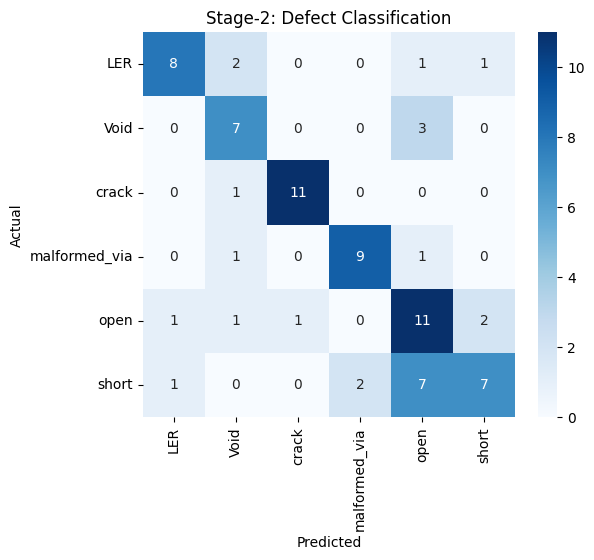

In [11]:
STAGE2_ROOT = "/kaggle/input/final-sem-data/sem-dataset/stage2"

train_l, val_l, test_l, classes = get_loaders(STAGE2_ROOT)
print("Stage-2 classes:", classes)

model_s2 = build_model(num_classes=len(classes))
train_model(model_s2, train_l, val_l)

torch.save(
    model_s2.state_dict(),
    "/kaggle/working/stage2_mobilenetv3.pth"
)

evaluate_model(
    model_s2, test_l,
    class_names=classes,
    title="Stage-2: Defect Classification"
)


In [12]:
ckpt = torch.load("/kaggle/working/stage2_mobilenetv3.pth", map_location="cpu")
print(ckpt.keys())
print(ckpt.get("class_to_idx"))

odict_keys(['features.0.0.weight', 'features.0.1.weight', 'features.0.1.bias', 'features.0.1.running_mean', 'features.0.1.running_var', 'features.0.1.num_batches_tracked', 'features.1.block.0.0.weight', 'features.1.block.0.1.weight', 'features.1.block.0.1.bias', 'features.1.block.0.1.running_mean', 'features.1.block.0.1.running_var', 'features.1.block.0.1.num_batches_tracked', 'features.1.block.1.fc1.weight', 'features.1.block.1.fc1.bias', 'features.1.block.1.fc2.weight', 'features.1.block.1.fc2.bias', 'features.1.block.2.0.weight', 'features.1.block.2.1.weight', 'features.1.block.2.1.bias', 'features.1.block.2.1.running_mean', 'features.1.block.2.1.running_var', 'features.1.block.2.1.num_batches_tracked', 'features.2.block.0.0.weight', 'features.2.block.0.1.weight', 'features.2.block.0.1.bias', 'features.2.block.0.1.running_mean', 'features.2.block.0.1.running_var', 'features.2.block.0.1.num_batches_tracked', 'features.2.block.1.0.weight', 'features.2.block.1.1.weight', 'features.2.bl

In [31]:
from collections import Counter

counts = Counter(train_ds.targets)
for k, v in counts.items():
    print(train_ds.classes[k], v)


NameError: name 'train_ds' is not defined

In [23]:
def two_stage_predict(img_tensor, stage1, stage2, stage2_classes):
    with torch.no_grad():
        if stage1(img_tensor).argmax(1).item() == 0:
            return "clean"
        else:
            idx = stage2(img_tensor).argmax(1).item()
            return stage2_classes[idx]


In [28]:
import torch
import torch.nn as nn
from torchvision import models

def create_mobilenetv3(num_classes):
    model = models.mobilenet_v3_small(weights=None)

    # Replace classifier head
    model.classifier[3] = nn.Linear(
        model.classifier[3].in_features,
        num_classes
    )
    return model


In [29]:
#save the model
model = create_mobilenetv3(num_classes=6)
model.load_state_dict(torch.load("/kaggle/working/stage2_mobilenetv3.pth", map_location="cpu"))
model.eval()



MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [30]:
import torch
import torch.nn as nn
from torchvision import models

DEVICE = "cpu"

def create_mobilenetv3(num_classes):
    model = models.mobilenet_v3_small(weights=None)
    model.classifier[3] = nn.Linear(
        model.classifier[3].in_features, num_classes
    )
    return model

# Stage-1
stage1_model = create_mobilenetv3(num_classes=2)
stage1_model.load_state_dict(
    torch.load("/kaggle/working/stage1_mobilenetv3.pth", map_location=DEVICE)
)
stage1_model.eval()


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [31]:
dummy_input = torch.randn(1, 3, 224, 224)

torch.onnx.export(
    stage1_model,
    dummy_input,
    "stage1_clean_defect.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}},
    opset_version=13
)


/tmp/ipykernel_55/271291844.py:3: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


In [32]:
import os

print(os.path.exists("stage1_clean_defect.onnx"))
print(os.path.getsize("stage1_clean_defect.onnx") / 1024 / 1024, "MB")


True
5.811701774597168 MB


In [33]:
# Stage-2
stage2_model = create_mobilenetv3(num_classes=6)
stage2_model.load_state_dict(
    torch.load("/kaggle/working/stage2_mobilenetv3.pth", map_location=DEVICE)
)
stage2_model.eval()


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [34]:
torch.onnx.export(
    stage2_model,
    dummy_input,
    "stage2_defect_type.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}},
    opset_version=13
)


/tmp/ipykernel_55/1972520003.py:1: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


In [35]:
import os

print(os.path.exists("stage2_defect_type.onnx"))
print(os.path.getsize("stage2_defect_type.onnx") / 1024 / 1024, "MB")


True
5.827343940734863 MB


In [36]:
#verify ONXX correctness
import onnx

onnx.checker.check_model(onnx.load("stage1_clean_defect.onnx"))
onnx.checker.check_model(onnx.load("stage2_defect_type.onnx"))

print("ONNX models are valid ✅")


ONNX models are valid ✅


**Model Inference**

In [39]:
import cv2
import numpy as np
import torch

def preprocess_pytorch(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))

    img = np.stack([img, img, img], axis=0)
    img = img.astype(np.float32) / 255.0

    mean = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
    std  = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)

    img = (img - mean) / std
    img = torch.tensor(img).unsqueeze(0)

    return img


In [41]:
stage1_model = create_mobilenetv3(num_classes=2)
stage1_model.load_state_dict(torch.load("/kaggle/working/stage1_mobilenetv3.pth", map_location="cpu"))
stage1_model.eval()

stage2_model = create_mobilenetv3(num_classes=6)
stage2_model.load_state_dict(torch.load("/kaggle/working/stage2_mobilenetv3.pth", map_location="cpu"))
stage2_model.eval()


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [43]:
def stage1_infer_pytorch(img_tensor):
    with torch.no_grad():
        out = stage1_model(img_tensor)
        prob = torch.softmax(out, dim=1)
        pred = prob.argmax(1).item()
        conf = prob.max().item()

    return ["clean", "defective"][pred], conf


In [44]:
stage2_classes = [
    "ler", "crack", "malformed_via",
    "open", "scratch", "short"
]

def stage2_infer_pytorch(img_tensor):
    with torch.no_grad():
        out = stage2_model(img_tensor)
        prob = torch.softmax(out, dim=1)
        pred = prob.argmax(1).item()
        conf = prob.max().item()

    return stage2_classes[pred], conf


In [45]:
def infer_sem_image(img_path):
    img = preprocess_pytorch(img_path)

    stage1_label, conf1 = stage1_infer_pytorch(img)

    if stage1_label == "clean":
        return {
            "stage1": "clean",
            "confidence": conf1
        }

    stage2_label, conf2 = stage2_infer_pytorch(img)

    return {
        "stage1": "defective",
        "confidence_stage1": conf1,
        "stage2": stage2_label,
        "confidence_stage2": conf2
    }


In [53]:

img_path = "/kaggle/input/test0033/Test/test_normal_01001.jpg"
result = infer_sem_image(img_path)
print(result)


RuntimeError: expected scalar type Double but found Float

In [54]:
onnx_path = "/kaggle/working/stage1_mobilenetv3.onnx"
torch.onnx.export(
    stage1_model,
    dummy_input,
    onnx_path,
    input_names=["input"],
    output_names=["output"],
    opset_version=13
)
print("Saved:", onnx_path)


/tmp/ipykernel_55/650540032.py:2: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Saved: /kaggle/working/stage1_mobilenetv3.onnx


In [55]:
onnx_path = "/kaggle/working/stage2_mobilenetv3.onnx"
torch.onnx.export(
    stage1_model,
    dummy_input,
    onnx_path,
    input_names=["input"],
    output_names=["output"],
    opset_version=13
)
print("Saved:", onnx_path)


/tmp/ipykernel_55/2792324050.py:2: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Saved: /kaggle/working/stage2_mobilenetv3.onnx


In [56]:
import zipfile
import os

zip_path = "/kaggle/working/onnx_models.zip"

with zipfile.ZipFile(zip_path, "w") as z:
    z.write("/kaggle/working/stage1_mobilenetv3.onnx", arcname="stage1.onnx")
    z.write("/kaggle/working/stage2_mobilenetv3.onnx", arcname="stage2.onnx")

print("ZIP ready:", zip_path)


ZIP ready: /kaggle/working/onnx_models.zip


In [ ]:
ckpt = torch.load("model.pth", map_location="cpu")
print(ckpt.keys())
print(ckpt.get("class_to_idx"))